In [33]:
import cv2
import time
from matplotlib import pyplot as plt
import os
from shutil import copyfile
import pandas as pd
import numpy as np

# Data Preprocessing

A portion of the preprocessing was done on a seperate notebook, it includes data augmentation and resizing all images to 320x320. 

In [2]:
classes = os.listdir("imgs")
print(classes)

['MT_Blowhole', 'MT_Break', 'MT_Crack', 'MT_Fray', 'MT_Free', 'MT_Uneven']


In [3]:
dirpath = lambda p : "imgs/"+p 

In [4]:
for i,classe in enumerate(classes):
    classes[i] = dirpath(classe)
print(classes)

['imgs/MT_Blowhole', 'imgs/MT_Break', 'imgs/MT_Crack', 'imgs/MT_Fray', 'imgs/MT_Free', 'imgs/MT_Uneven']


In [5]:
images= []
categories = []
for c in classes:
    cat = c.split("_")[1] 
    file_list = [os.path.join(c,i) for i in os.listdir(c) if i[0]!="."]
    len_list = len(file_list)
    images.extend(file_list)
    cats = [cat] * len_list
    categories.extend( cats)

In [6]:
width=[]
height=[]
for im in images:
    img = cv2.imread(im)
    width.append(img.shape[0])
    height.append(img.shape[1])

### Creating data frame

In [7]:
df = pd.DataFrame()
df["img_path"] = images
df["category"] = categories
df["width"] = width
df["height"] = height

In [8]:
from sklearn.utils import shuffle
df = shuffle(df)

C:\Users\newgh\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
df.head()

,img_path,category,width,height
3268,imgs/MT_Free\exp4_num_10957.jpg,Free,320,320
3387,imgs/MT_Free\exp4_num_269136rotated.jpg,Free,320,320
1291,imgs/MT_Break\exp4_num_26163rotatedfliped.jpg,Break,320,320
519,imgs/MT_Blowhole\exp4_num_308078upsidedownflip...,Blowhole,320,320
41,imgs/MT_Blowhole\exp1_num_297464fliped.jpg,Blowhole,320,320


### Data visualization

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
from random import sample
from PIL import Image

<AxesSubplot:xlabel='category', ylabel='count'>

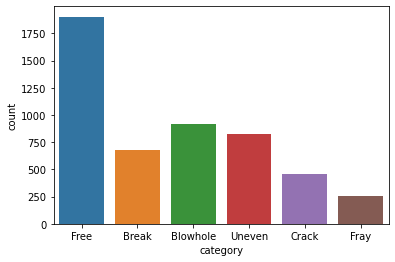

In [11]:
sns.countplot(x = df.category)

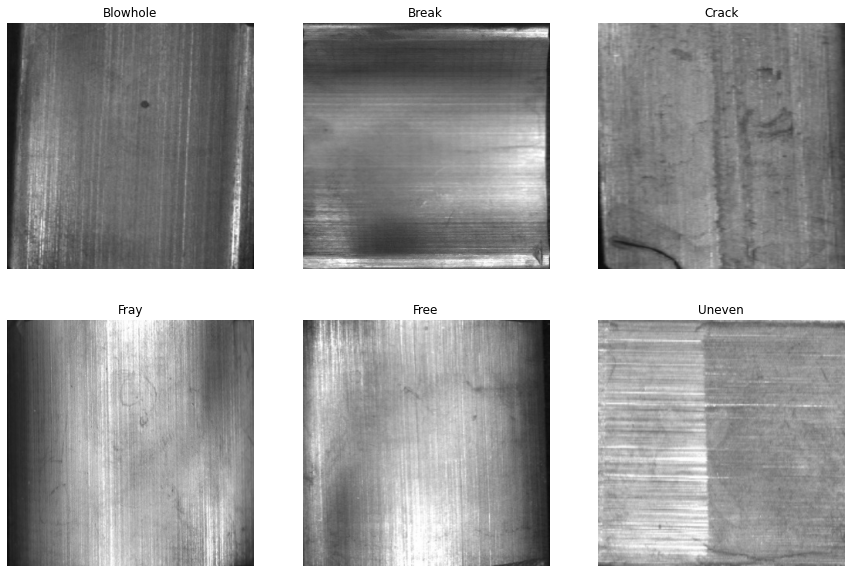

In [60]:
fig = plt.figure(figsize=(15,10))
i = 1
for c in classes:
    fig.add_subplot(2, 3, i)
    random_sample = sample(os.listdir(c),1)[0]
    img = np.asarray(Image.open( os.path.join( c , random_sample) ))
    plt.imshow(img)
    plt.axis('off')
    plt.title(c.split("_")[1])
    i = i + 1
plt.show()

#### splitting data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_df, test_df = train_test_split(df, test_size = 0.3)

# Model training and testing

In [20]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Data Generator

In [15]:
datagen = ImageDataGenerator(rescale=1.0/255.)

In [16]:
batch_size = 8
target_size=(299, 299)

train_generator = datagen.flow_from_dataframe(train_df,x_col='img_path', y_col='category',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=target_size)

test_generator = datagen.flow_from_dataframe(test_df,x_col='img_path', y_col='category',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=target_size)

Found 3528 validated image filenames belonging to 6 classes.
Found 1512 validated image filenames belonging to 6 classes.


In [51]:
from keras.backend import set_session

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)
set_session(sess)

sess.close()
tf.compat.v1.reset_default_graph()

### Transfer Learning

In [17]:
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Dropout

In [18]:
base_model = Xception()
base_model.trainable = True
base_model = tf.keras.Model(base_model.layers[0].input,base_model.layers[-2].output)
inputs = Input(shape=(299, 299, 3))
pretrained = base_model(inputs, training=True)
layer = Dense(1024, activation='relu')(pretrained)
layer = Dropout(0.5)(layer)
output = Dense(units=6, activation='softmax')(layer)
model = tf.keras.Model(inputs, output)

In [21]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [22]:
history = model.fit(train_generator,
                    validation_data= test_generator,
                    epochs=4,
                    verbose=1)

Epoch 1/4
441/441 [==============================] - 487s 1s/step - loss: 0.6410 - categorical_accuracy: 0.7769 - val_loss: 0.1896 - val_categorical_accuracy: 0.9458
Epoch 2/4
441/441 [==============================] - 521s 1s/step - loss: 0.1403 - categorical_accuracy: 0.9598 - val_loss: 0.0952 - val_categorical_accuracy: 0.9775
Epoch 3/4
441/441 [==============================] - 535s 1s/step - loss: 0.0782 - categorical_accuracy: 0.9773 - val_loss: 0.0996 - val_categorical_accuracy: 0.9749
Epoch 4/4
441/441 [==============================] - 545s 1s/step - loss: 0.0651 - categorical_accuracy: 0.9836 - val_loss: 0.0721 - val_categorical_accuracy: 0.9775


### Results

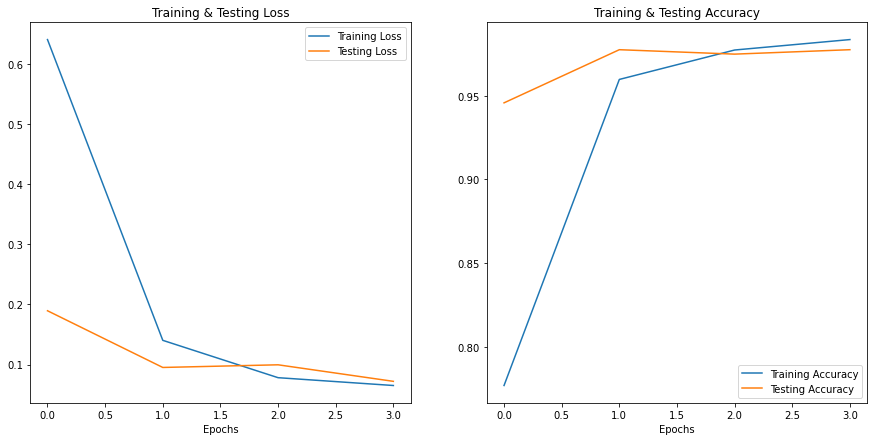

In [26]:
epochs = [i for i in range(4)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['categorical_accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_categorical_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(15,7)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [47]:
model.save("metallic_surface_classifier")

INFO:tensorflow:Assets written to: metallic_surface_classifier\assets


INFO:tensorflow:Assets written to: metallic_surface_classifier\assets
